# Projeto 1 - Ciência dos Dados

Nome: Alex Souza Pacchioni

Nome: Rafael Dourado Bastos de Oliveira

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
Carregando algumas bibliotecas:

In [307]:
%matplotlib inline
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sn
from IPython.display import display

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Rafael
[nltk_data]     Dourado\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [308]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
c:\Users\Rafael Dourado\Desktop\Programação\Insper\cdados\22-2a-cd-p1-grupo_rafaeldbo\notebooks


Carregando a base de dados com as notícias classificadas manualmente:

In [309]:
path = '../data/'
filename = 'dados.xlsx'

In [310]:
train = pd.read_excel(path+filename, sheet_name = 'Treinamento')
test = pd.read_excel(path+filename, sheet_name = 'Teste')

___
## Classificador automático


Faça aqui uma descrição do seu assunto e o que considerou como relevante ou não relevante na classificação das notícias (Target).

ESCREVA AQUI...

___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

In [311]:
#Limpador
stop_words = nltk.corpus.stopwords.words('portuguese')
special_characters= ',.@!#$%¨&*()–_-“”:;+‘’={}[]]?/\|…""><—'+"''"

def cleanup (text):
    text = text.strip().lower()
    for word in special_characters:
        text = text.replace(word, " ")

    text = text.strip().split()
    clean_text = []
    for word in text:
        if (word in stop_words) or (word.isnumeric()) or (len(word) <= 1):
            text.remove(word)

    return text

train["Texto"] = train["Descrição"].apply(cleanup)

In [312]:
# Coletando todas as palavras
all_words = []
for words_list in train['Texto']:
    all_words += words_list
all_words = pd.Series(all_words)
portuguese = list(set(all_words))

for word in all_words[0:1000]:
    print(word, end=" ")

estudo faculdade medicina universidade hong kong hkumed sigla inglês analisou capacidade replicação variante ômicron indicou ela pode de fato transmissível porém causar quadros infecciosos menos severos pesquisadores destacaram mesmo severidade reduzida risco global linhagem provavelmente crescente popularidade impulsionado aumento crimes relacionados tokens fungíveis nfts eles lavagem dinheiro a negociação lavagem segundo chainalysis empresa monitora tecnologias blockchain suas aplicações evidência significativa práticas ilegais mercado colecionáveis digitais exclusivos 2021 negociados 44 variante ba cepa ômicron coronavírus é severa que original informou organização mundial saúde oms nesta terça feira base amostra pessoas diferentes países estamos vendo diferença severidade da ba em comparação com a ba disse maria van kerkhove alta funcionária número novos casos mortes covid nas américas diminuiu ainda existem áreas vulneráveis o caribe informou organização pan americana saúde opas n

In [313]:
# Filtrando a base de treino para cada target
train_irrelevant = train.loc[train["Target"] == 0, :]
train_bad = train.loc[train["Target"] == 1, :]
train_neutral = train.loc[train["Target"] == 2, :]
train_good = train.loc[train["Target"] == 3, :]

# Criando um series para cada target
series_irrelevant = pd.Series(train_irrelevant["Texto"].sum(axis= 0))
series_bad = pd.Series(train_bad["Texto"].sum(axis= 0))
series_neutral = pd.Series(train_neutral["Texto"].sum(axis= 0))
series_good = pd.Series(train_good["Texto"].sum(axis= 0))

# Fazendo a frequencia absoluta
table_irrelevant = series_irrelevant.value_counts()
table_bad = series_bad.value_counts()
table_neutral = series_neutral.value_counts()
table_good = series_good.value_counts()

# Fazendo a probabilidade de cada target
prob_irrelevant = (len(series_irrelevant)/len(all_words))
prob_bad = (len(series_bad)/len(all_words))
prob_neutral = (len(series_neutral)/len(all_words))
prob_good = (len(series_good)/len(all_words))

In [314]:
# Suavizador de Laplace
def laplace_smoothing(words_list, amount):
    laplace_amount = amount + 1
    density = len(words_list) + len(portuguese)
    laplace = laplace_amount/density
    return laplace

# Função probabilidade do target 
def probability_target(table_target, series_target, news):
    
    list_target= []
    for word in news:
        if word in table_target.keys():
            amount = table_target[word]
        else:
            amount = 0
        list_target.append(laplace_smoothing(series_target, amount))
        
    probability_target = np.prod(list_target)
    return probability_target

# Função do Naive Bayes
def naive_bayes(news):
    prob_0 = probability_target(table_irrelevant, series_irrelevant, news) * prob_irrelevant
    prob_1 = probability_target(table_bad, series_bad, news) * prob_bad
    prob_2 = probability_target(table_neutral, series_neutral, news) * prob_neutral
    prob_3 = probability_target(table_good, series_good, news) * prob_good

    list_probs = [prob_0, prob_1, prob_2, prob_3]
    target = list_probs.index(max(list_probs))

    return target

In [315]:
test["Texto"] = test["Descrição"].apply(cleanup)
test["Classificacao"] = test["Texto"].apply(naive_bayes)

performance_table = pd.crosstab(test["Classificacao"], test["Target"], normalize=True)

Text(60.0, 0.5, 'Classificação Manual')

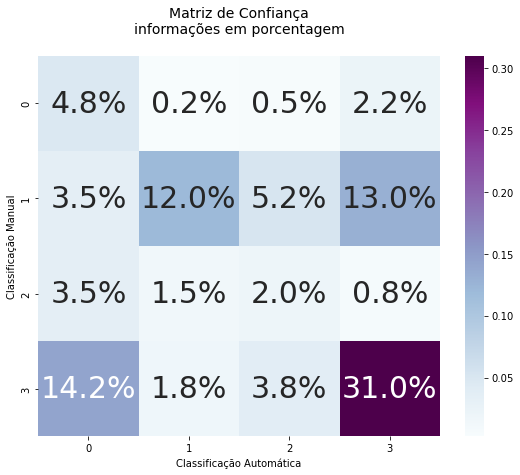

In [316]:
plt.figure(figsize = (9,7))
plt.title('Matriz de Confiança\ninformações em porcentagem\n',fontdict={'fontsize': 14})
sn.heatmap(performance_table, annot=True, annot_kws={"size":30},fmt='.1%',cmap="BuPu")
plt.xlabel('Classificação Automática')
plt.ylabel('Classificação Manual')

In [319]:
true_positives = performance_table[0][0]+performance_table[1][1]+performance_table[2][2]+performance_table[3][3]
print(f'Verdaveiros Positivos: {round(true_positives, 4)*100}%')
print(f'Falsos Positivos: {round(1 - true_positives, 4)*100}%')

Verdaveiros Positivos: 49.75%
Falsos Positivos: 50.24999999999999%


___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

___
### Concluindo

___
### Qualidade do Classificador a partir de novas separações das notícias entre Treinamento e Teste

Caso for fazer esse item do Projeto

___
## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nas notícias. Ex: stemming, lemmatization, stopwords
* CONSIDEROU mais de duas caterogias na variável Target e INCREMENTOU a quantidade de notícias, mantendo pelo menos 250 notícias por caterogia (OBRIGATÓRIO PARA TRIOS, sem contar como item avançado)
* Para Target com duas categorias: CRIOU pelo menos quatro categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante
* EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento
* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto (pelo menos dois cenários, exceto aqueles já apresentados em sala pelos professores: por exemplo, filtro de spam)
* SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* FEZ o item Qualidade do Classificador a partir de novas separações das Notícias entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+)

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**